# Instalando Bibliotecas


In [ ]:
# Importando bibliotecas
import pandas as pd
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
import numpy as np
import networkx as nx
!pip install plotly.express
from plotly import graph_objs as go

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


# Exemplo de Remoção de Stopwords

In [ ]:
# remoção de pontuacao e stopwords

def remove_stopwords(text,lang,domain_stopwords=[]):

  stop_words = nltk.corpus.stopwords.words(lang) # lang='portuguese' or lang='english'

  s = str(text).lower() # tudo para caixa baixa
  table = str.maketrans({key: None for key in string.punctuation})
  s = s.translate(table) # remove pontuacao
  tokens = word_tokenize(s) #obtem tokens
  v = [i for i in tokens if not i in stop_words and not i in domain_stopwords and not i.isdigit()] # remove stopwords
  s = ""
  for token in v:
    s += token+" "
  return s.strip()


# exemplos de uso
text = "O estudante de Inteligência Artificial foi na livraria comprar  livros para estudar."
text2 = remove_stopwords(text, 'portuguese')
print('Antes: '+text)
print('Depois: '+text2)

Antes: O estudante de Inteligência Artificial foi na livraria comprar  livros para estudar.
Depois: estudante inteligência artificial livraria comprar livros estudar


# Exemplo de Stemming/Radicalização de Termos

In [ ]:
# stemming
def stemming(text,lang):

  stemmer = PorterStemmer() # stemming para ingles

  if lang=='portuguese':
    stemmer = nltk.stem.RSLPStemmer() # stemming para portuguese

  tokens = word_tokenize(text) #obtem tokens

  sentence_stem = ''
  doc_text_stems = [stemmer.stem(i) for i in tokens]
  for stem in doc_text_stems:
    sentence_stem += stem+" "

  return sentence_stem.strip()


# exemplos de uso
text = "O estudante de Inteligência Artificial foi na livraria comprar livros para estudar."
text2 = remove_stopwords(text, 'portuguese')
text3 = stemming(text2, 'portuguese')
print('Antes: '+text)
print('Depois: '+text3)

Antes: O estudante de Inteligência Artificial foi na livraria comprar livros para estudar.
Depois: estud intelig artific livr compr livr estud


# Coletando uma Base de Textos para Testar

In [ ]:
import urllib.parse
# obtendo dataset com uma amostra de textos

query = "febre amarela" # query para consultar
query = urllib.parse.quote(query)

pd.set_option('display.max_colwidth', -1)
dataset = pd.read_csv('http://websensors.net.br/minicurso/2019/eventos-br-2017.php?q='+query,sep='\t', lineterminator='\n')
dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,event_id,date,title,local,url,lat,lng
0,b4b29e9b5537c1896129029bd976438c,2017-01-05 15:27:28,"Após 2ª morte por febre amarela em SP, vacinação é intensificada - Globo.com",Ribeirao Preto (SP),http://g1.globo.com/sp/ribeirao-preto-franca/noticia/2017/01/apos-2-morte-por-febre-amarela-em-sp-vacinacao-e-intensificada.html,-21.17,-47.81
1,125bf6fbeef15b17a1d4837127129bbe,2017-01-08 16:04:51,Casos de febre amarela em macacos na região preocupam ... - Globo.com,Ribeirao Preto (SP),http://g1.globo.com/sao-paulo/sao-jose-do-rio-preto-aracatuba/alerta-dengue/noticia/2017/01/avanco-da-febre-amarela-na-regiao-preocupa-moradores-e-autoridades.html,-21.17,-47.81
2,aff14d48f09878b31e0575971fc8fec2,2017-01-08 14:04:51,G1 - Casos de febre amarela em macacos na região preocupam ... - Globo.com,Sao Jose do Rio Preto (SP),http://g1.globo.com/sao-paulo/sao-jose-do-rio-preto-aracatuba/alerta-dengue/noticia/2017/01/avanco-da-febre-amarela-na-regiao-preocupa-moradores-e-autoridades.html,-20.82,-49.37
3,ca7ca58720fc9a2338894095ba6409f0,2017-01-05 13:27:28,"Após 2ª morte por febre amarela em SP, vacinação é intensificada - Globo.com",Sao Jose do Rio Preto (SP),http://g1.globo.com/sp/ribeirao-preto-franca/noticia/2017/01/apos-2-morte-por-febre-amarela-em-sp-vacinacao-e-intensificada.html,-20.82,-49.37
4,2a6e78e1226fc9c5f1c9061febf175d1,2017-01-09 14:57:25,Mortes por febre amarela põem em alerta cidades do norte paulista - Istoe,Sao Jose do Rio Preto (SP),http://istoe.com.br/mortes-por-febre-amarela-poem-em-alerta-cidades-do-norte-paulista/,-20.82,-49.37
...,...,...,...,...,...,...,...
295,eb1bf464427f72b429d4d026cd03c15a,2017-01-16 13:26:34,Casos de febre amarela dobram na cidade mais afetada por surto ... - Jornal O Globo,Teofilo Otoni (MG),http://oglobo.globo.com/sociedade/saude/casos-de-febre-amarela-dobram-na-cidade-mais-afetada-por-surto-em-mg-20780480,-17.85,-41.50
296,4011697d8b30ee8b4ef7eba723b4d123,2017-01-16 18:34:04,"Mortes suspeitas por febre amarela sobem para 47 em Minas, diz governo - Globo.com",Guarapari (ES),http://news.google.com/news/url?sa=t&amp;fd=R&amp;ct2=pt-BR_br&amp;usg=AFQjCNGndFS8CsOVRLxukpOQSm61GvywHg&amp;clid=c3a7d30bb8a4878e06b80cf16b898331&amp;cid=52779918976016&amp;ei=UlN9WODZK8mhzALDvQU&amp;url=http://g1.globo.com/minas-gerais/noticia/mortes-suspeitas-por-febre-amarela-sobem-para-47-em-minas-diz-governo.ghtml,-20.65,-40.51
297,cb4d96cd6373d865ca0e3d4c71689fff,2017-01-16 21:25:40,Áreas endêmicas de Febre Amarela são monitoradas no Maranhão,Sao Luis (MA),http://g1.globo.com/ma/maranhao/noticia/2017/01/areas-endemicas-de-febre-amarela-sao-monitoradas-no-maranhao.html,-2.53,-44.30
298,9e5608325882b701c343427999d2c4e9,2017-01-16 18:30:41,"Casos suspeitos de febre amarela em MG sobem para 152, com 47 mortes - Jornal O Globo",Coronel Fabriciano (MG),http://oglobo.globo.com/sociedade/saude/casos-suspeitos-de-febre-amarela-em-mg-sobem-para-152-com-47-mortes-20783045,-19.51,-42.62


In [ ]:
# filtrando apenas o título
dataset = dataset[['title']]
dataset

,title
0,"Após 2ª morte por febre amarela em SP, vacinação é intensificada - Globo.com"
1,Casos de febre amarela em macacos na região preocupam ... - Globo.com
2,G1 - Casos de febre amarela em macacos na região preocupam ... - Globo.com
3,"Após 2ª morte por febre amarela em SP, vacinação é intensificada - Globo.com"
4,Mortes por febre amarela põem em alerta cidades do norte paulista - Istoe
...,...
295,Casos de febre amarela dobram na cidade mais afetada por surto ... - Jornal O Globo
296,"Mortes suspeitas por febre amarela sobem para 47 em Minas, diz governo - Globo.com"
297,Áreas endêmicas de Febre Amarela são monitoradas no Maranhão
298,"Casos suspeitos de febre amarela em MG sobem para 152, com 47 mortes - Jornal O Globo"


# Computando uma Bag-of-Words

In [ ]:
# obtendo a bag-of-words
def compute_bag_of_words(dataset,lang,domain_stopwords=[]):

  d = []
  for index,row in dataset.iterrows():
    text = row['title'] #texto do evento
    text2 = remove_stopwords(text, lang,domain_stopwords)
    text3 = stemming(text2, lang)
    d.append(text3)

  matrix = CountVectorizer(max_features=1000)
  X = matrix.fit_transform(d)

  count_vect_df = pd.DataFrame(X.todense(), columns=matrix.get_feature_names())

  return count_vect_df


bow = compute_bag_of_words(dataset,'portuguese')
bow

,2ª,3ª,acab,adot,afet,afirm,alago,alarm,alert,algum,almg,amarel,ano,anunc,apo,apont,apur,após,ar,aracaju,arax,assinat,atend,atenç,atest,ating,atrás,aument,bah,baian,barbacen,barr,bh,biólog,blasting,blog,bom,bomb,brasil,calam,...,solicit,som,sp,surt,suspeit,tabapuã,temp,ter,terc,teófil,tir,to,tod,tragéd,tranquiliz,tripl,troc,trê,turist,uberab,un,unidad,uol,urban,vacin,vai,val,valad,vej,vint,vir,vitór,viv,volt,votuporang,vítim,wwwaquinoticiascom,zon,áre,óbit
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
296,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
297,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
298,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Ponderação de Termos com TFIDF

In [ ]:
# obtendo a VSM com TFIDF
def compute_vsm_tfidf(dataset,lang,domain_stopwords=[]):

  d = []
  for index,row in dataset.iterrows():
    text = row['title'] #texto do evento
    text2 = remove_stopwords(text, lang,domain_stopwords)
    text3 = stemming(text2, lang)
    d.append(text3)

  matrix = TfidfVectorizer()
  X = matrix.fit_transform(d)

  tfidf_vect_df = pd.DataFrame(X.todense(), columns=matrix.get_feature_names())

  return tfidf_vect_df


vsm = compute_vsm_tfidf(dataset,'portuguese')
vsm

,2ª,3ª,acab,adot,afet,afirm,alago,alarm,alert,algum,almg,amarel,ano,anunc,apo,apont,apur,após,ar,aracaju,arax,assinat,atend,atenç,atest,ating,atrás,aument,bah,baian,barbacen,barr,bh,biólog,blasting,blog,bom,bomb,brasil,calam,...,solicit,som,sp,surt,suspeit,tabapuã,temp,ter,terc,teófil,tir,to,tod,tragéd,tranquiliz,tripl,troc,trê,turist,uberab,un,unidad,uol,urban,vacin,vai,val,valad,vej,vint,vir,vitór,viv,volt,votuporang,vítim,wwwaquinoticiascom,zon,áre,óbit
0,0.464088,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.100285,0.0,0.0,0.0,0.0,0.0,0.401048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.464088,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.129232,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.106486,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.464088,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.100285,0.0,0.0,0.0,0.0,0.0,0.401048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.464088,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.371335,0.0,0.0,0.075546,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.000000,0.0,0.0,0.0,0.491501,0.0,0.0,0.0,0.000000,0.0,0.0,0.087635,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.246718,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
296,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.125853,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.276406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
297,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.085595,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436337,0.0
298,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.113656,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

# Exemplo de Agrupamento Particional

In [ ]:
# preparando os dados para o k-means

X = np.array(vsm)
length = np.sqrt((X**2).sum(axis=1))[:,None]
X = X / length

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=20).fit(X)
kmeans.labels_

df_ = vsm
df_['grupo'] = kmeans.labels_
df_

,2ª,3ª,acab,adot,afet,afirm,alago,alarm,alert,algum,almg,amarel,ano,anunc,apo,apont,apur,após,ar,aracaju,arax,assinat,atend,atenç,atest,ating,atrás,aument,bah,baian,barbacen,barr,bh,biólog,blasting,blog,bom,bomb,brasil,calam,...,som,sp,surt,suspeit,tabapuã,temp,ter,terc,teófil,tir,to,tod,tragéd,tranquiliz,tripl,troc,trê,turist,uberab,un,unidad,uol,urban,vacin,vai,val,valad,vej,vint,vir,vitór,viv,volt,votuporang,vítim,wwwaquinoticiascom,zon,áre,óbit,grupo
0,0.464088,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.100285,0.0,0.0,0.0,0.0,0.0,0.401048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.464088,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.129232,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,15
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.106486,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,15
3,0.464088,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.100285,0.0,0.0,0.0,0.0,0.0,0.401048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.464088,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.371335,0.0,0.0,0.075546,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.000000,0.0,0.0,0.0,0.491501,0.0,0.0,0.0,0.000000,0.0,0.0,0.087635,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.246718,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,18
296,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.125853,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.276406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2
297,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.085595,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436337,0.0,4
298,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.113656,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0000

In [ ]:
df_[['grupo']]

,grupo
0,0
1,1
2,1
3,0
4,0
...,...
295,0
296,0
297,0
298,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb77b6e2a58>]],
      dtype=object)

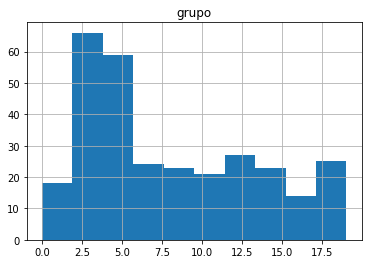

In [ ]:
df_[['grupo']].hist()